#### Exercise 9 - Solution - Event Study Staggered Rollout

Use stock market data to estimate the impact of the ex-dividend data on stock prices. The ex-dividend date is the first trading date after the dividend record date. Whoever owns the stock on the record date receives the dividend, so purchasing a dividend-paying stock on the ex-dividend date means you've just missed the payout and now have to wait another quarter (typically) until the next payout.

It's often assumed that if markets are efficient that the value of the company should drop on the ex-dividend date because the company is about to distribute cash that a new buyer would not receive, and that's the longest period for which a new buyer would have to wait for the dividend. Let's test this theory by evaluating the incremental price change (net of market performance) on ex-dividend dates for a select group of dividend-paying stocks. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [3]:
ex_dividend_dates = {'XOM':'2025-05-15' ,
                     'JNJ':'2025-05-27',
                     'CVX':'2025-05-19',
                     'PG':'2025-04-21',
                     'PM':'2025-03-20'}

targets = list(ex_dividend_dates.keys())



In [4]:
rawdata = pd.read_csv('../data/staggered_rollout_dividends.csv', parse_dates=['date'])
colnames = rawdata.columns.tolist()
colnames.append('trend')

tickers = rawdata['target_ticker'].unique()

for ticker in tickers:
    tmp = rawdata[rawdata['target_ticker']==ticker].copy()
    tmp['t'] = range(1, len(tmp) + 1)

    event_date = ex_dividend_dates[ticker]
    event_index = tmp.loc[tmp['date'] == event_date, 't'].values[0]
    tmp['trend'] = tmp['t'] - event_index
    tmp.drop(columns=['t'], inplace=True)
    if ticker == tickers[0]:
        staggered_df = tmp
    else:
        staggered_df = pd.concat([staggered_df, tmp], axis=0)

staggered_df[staggered_df['trend']==0]

,target,VOO,VTI,QQQ,DVY,date,target_ticker,trend
61,0.000922,0.004906,0.004077,0.001099,0.013386,2025-05-15,XOM,0
127,0.002027,0.020548,0.020558,0.023525,0.013889,2025-05-27,JNJ,0
194,-0.025405,0.001025,0.000786,0.000959,0.001196,2025-05-19,CVX,0
260,-0.028600,-0.023827,-0.023768,-0.024747,-0.017956,2025-04-21,PG,0
323,-0.011796,-0.002302,-0.002398,-0.003390,-0.002690,2025-03-20,PM,0


### Estimate event study model

In [5]:
subset = staggered_df[(staggered_df['trend'] >= -60) & (staggered_df['trend'] < 1)].copy()
subset['event'] = np.where(subset['trend']==0,1,0)

formula = 'target~VOO+VTI+QQQ+DVY+event'
model = smf.ols(formula=formula, data=subset).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     37.39
Date:                Wed, 13 Aug 2025   Prob (F-statistic):           1.10e-29
Time:                        21:00:08   Log-Likelihood:                 845.62
No. Observations:                 303   AIC:                            -1679.
Df Residuals:                     297   BIC:                            -1657.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0007      0.001      0.793      0.4

In [6]:
subset = staggered_df[(staggered_df['trend'] >= -60) & (staggered_df['trend'] < 4)].copy()

subset['pre1'] = subset['trend'].apply(lambda x: 1 if x == -1 else 0)
subset['pre2'] = subset['trend'].apply(lambda x: 1 if x == -2 else 0)
subset['pre3'] = subset['trend'].apply(lambda x: 1 if x == -3 else 0)
subset['post0'] = subset['trend'].apply(lambda x: 1 if x == 0 else 0)
subset['post1'] = subset['trend'].apply(lambda x: 1 if x == 1 else 0)
subset['post2'] = subset['trend'].apply(lambda x: 1 if x == 2 else 0)
subset['post3'] = subset['trend'].apply(lambda x: 1 if x == 3 else 0)

formula = 'target~VOO+VTI+QQQ+DVY+pre3+pre2+pre1+post0+post1+post2+post3'
model = smf.ols(formula=formula, data=subset).fit()
print(model.summary())

#BONUS: model = smf.ols(formula=formula, data=subset).fit(cov_type='cluster', cov_kwds={'groups': subset['date']})


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     17.11
Date:                Wed, 13 Aug 2025   Prob (F-statistic):           2.66e-26
Time:                        21:00:08   Log-Likelihood:                 889.88
No. Observations:                 318   AIC:                            -1756.
Df Residuals:                     306   BIC:                            -1711.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0006      0.001      0.681      0.4

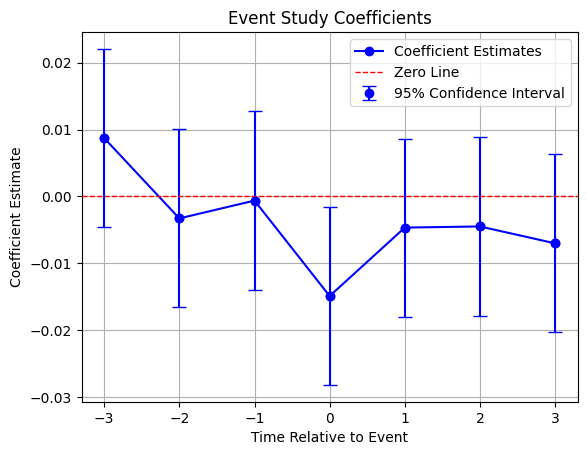

In [7]:
# Extract coefficients for pre3, pre2, pre1, post0, post1, post2, and post3
coefficients = ['pre3', 'pre2', 'pre1', 'post0', 'post1', 'post2', 'post3']
x_values = range(-3, 4)  # x values from -3 to +3
y_values = [model.params[coef] for coef in coefficients]

# Add error bars using standard errors from model.bse
y_errors = [1.96*model.bse[coef] for coef in coefficients]

# Plot the coefficient estimates as a connected line graph
plt.plot(x_values, y_values, marker='o', color='b', label='Coefficient Estimates')

# Add error bars to the plot
plt.errorbar(x_values, y_values, yerr=y_errors, fmt='o', color='b', capsize=5, label='95% Confidence Interval')
plt.title('Event Study Coefficients')
plt.xlabel('Time Relative to Event')
plt.ylabel('Coefficient Estimate')
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Line')
plt.xticks(x_values)
plt.legend()
plt.grid(True)
plt.show()